### Imports & Configs

In [1]:
import torch
import torch.nn as NN
import torchvision

from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import ImageFolder
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomGrayscale, Compose, GaussianBlur, ToTensor, RandomApply

import torchvision.models as models

import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt

D:\Python\pytorch\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)

1.13.1+cu117


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### SimCLR is based out of the following simplified modules:

* A stochastic data augmentation module.
* A neural network base encoder  f(.)
* A neural network projection head  g(.)
* A contrastive loss function.

### Stochastic Augmentation

* Author suggest that composition of data augmentation operations is crucial for learning good representations.
* Contrastive learning needs stronger data augmentation than supervised learning


In [7]:
def complete_image_transform(output_shape, kernel_size, s=1.0):
    """
    This method will transform the image as suggested by author
    - Random Crop with Resize
    - Random Horizontal Flip with 50% probability
    - Random Color Distortion
       - Random Color Jitter with 80% probability
       - Random Color Drop with 20% probability
    - Random Gaussian Blur with 50% probability
    
    s = filter strength paramter 
    """
    random_crop = RandomResizedCrop(output_shape)
    random_flip = RandomHorizontalFlip(p=0.5)
    
    color_jitter = ColorJitter(brightness=0.8*s, contrast=0.8*s, saturation=0.8*s, hue=0.2*s)
    random_color_jitter = RandomApply([color_jitter], p=0.8)
    
    random_gray = RandomGrayscale(p=0.2)
    gaussian_blur = GaussianBlur(kernel_size=kernel_size)
    random_gaussian_blur = RandomApply([gaussian_blur], p=0.5)
    
    to_tensor = ToTensor()
    
    image_transform = Compose([
        to_tensor,
        random_crop,
        random_flip,
        random_color_jitter,
        random_gray,
        random_gaussian_blur        
    ])
    return image_transform
    
class ContrastiveLearningViewGenerator(object):
    def __init__(self, base_transform, n_views = 2):
        self.base_transform = base_transform
        self.n_views = n_views
        
    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

### Prepare Data

* _torch.utils.data_ is the main class which help us in loading the data and iterating over it
* **torch.utils.data.DataSet** -> helps encapsulating raw data
* **torch.utils.data.DataLoader** -> helps iterating over the dataset

In [8]:
class BuildCustomData(Dataset):
    def __init__(self, list_images, transform=None):
        self.list_images = list_images
        self.transform = transform
        
    def __len__(self):
        return len(self.list_images)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_name = self.list_images[idx]
        image = io.imread(image_name)
        if self.transform:
            image = self.transform(image)
            
        return image

In [33]:
# the size of images 
output_shape = [224, 224] # as we use standard Inception-style random cropping we will use 224 x 224 image to transform and random crop
kernel_size = [21,21] # We blur the image 50% of the time using a Gaussian kernel. The kernel size is set to be 10% of the image height/width.

# custom transformation of images (calling method above)

base_transform = complete_image_transform(output_shape=output_shape, kernel_size=kernel_size, s=1.0)

custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transform)
list_images = glob.glob("../data/flowers/*/*.jpg")
flowers_dataset = BuildCustomData(list_images= list_images, transform=custom_transform)

In [34]:
print("total images in the dataset:",len(flowers_dataset))

total images in the dataset: 4317


C:\Users\adity\AppData\Local\Temp\ipykernel_9188\20202179.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,2,2*i)


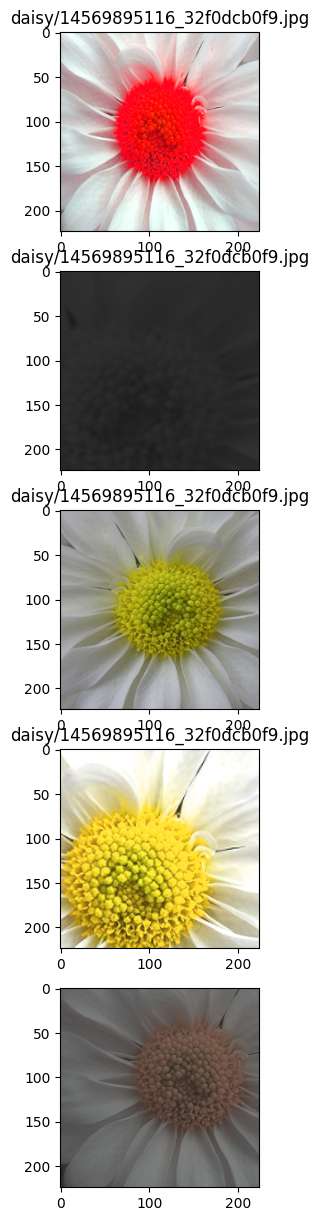

In [47]:
plt.figure(figsize=(25, 15))
def visualize_image(flowers, index):
    for i in range(1,6):
        images = flowers[index]
        v1, v2 = images
        plt.title("/".join(list_images[100].split("\\")[-2:]))
        plt.imshow(v1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(v2.permute(1,2,0))
        
visualize_image(flowers_dataset, 0) 